## I. IMPORT LIBRARIES AND ESSENTIAL FUNCTIONS

In [ ]:
# Mount Google drive locally
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

!pip install --quiet tensorflow-text
!pip install tensorflow_text
import tensorflow_text as text

import os

# Install Transformers library 
!pip install transformers

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('dark_background')

     |████████████████████████████████| 4.4 MB 8.8 MB/s 
     |████████████████████████████████| 2.9 MB 8.9 MB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
     |████████████████████████████████| 3.3 MB 42.6 MB/s 
     |████████████████████████████████| 895 kB 34.8 MB/s 
     |████████████████████████████████| 56 kB 3.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## II. GET AND OVERVIEW THE RAW DATASET



In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


* There are 5 class: BACKGROUND, OBJECTIVE, METHODS, RESULTS, CONCLUSIONS

In [ ]:
# Check the files inside PubMed_200k_RCT_numbers_replaced_with_at_sign
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


Comments:

The dataset contains 3 files, which are:
* dev.txt = validation set
* test.txt = test set
* train.zip = train set

In [ ]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
# Check all filenames inside the data_dir
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
# Create a function to read a text filename and return the lines of text as a list
def get_lines(filename):
    with open(filename, 'r') as f:
        return f.readlines()

In [ ]:
# Read the lines from dev, train, and test.txt to the appropriate lists (for 20k dataset)
train_list = get_lines('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')
val_list = get_lines('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')
test_list = get_lines('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')

In [ ]:
train_list[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [ ]:
val_list[:5]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n']

In [ ]:
test_list[:5]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n']

Comments: the data is in list form
* Beginning: each abstract starts with "###numerical_id\n" format
* Ending: an empty new line "\n"
* Content: each line ob sentences includes: label + \t (tab seperated) + sentence

In [ ]:
len(train_list), len(val_list), len(test_list)

(210040, 35212, 35135)

## III. PREPROCESS DATA & EDA

In [ ]:
def preprocess_text_with_line_number(filename):
    input_lines = get_lines(filename) # get the list of all lines from filename
    abstract_lines = '' # create an empty abstract
    abstract_dataset = [] # create an empty list of abstracts

    for line in input_lines:
        if line.startswith('###'): # check whether the line is an ID line
            abstract_id = line
            abstract_lines = '' # reset the abstract string if the line is an ID line

        elif line.isspace(): # check whether the line is a new line "\n"
            abstract_line_split = abstract_lines.splitlines() # split abstract into a list of seperate line

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split): # loop and create the tuple of each line number and the line content
                line_data = {} # create an empty dictionary for each line
                label_text_split = abstract_line.split('\t') # split label from text
                line_data['label'] = label_text_split[0] # get label
                line_data['text'] = label_text_split[1].lower() # get target text and lower so as to prevent bias between captialized and uncapitalized words
                line_data['line_number'] = abstract_line_number # the order that the line appears in the abstract
                line_data['total_lines'] = len(abstract_line_split) - 1 # total number of line in an abstract
                abstract_dataset.append(line_data) # add line data to abstract samples list

        else: # if the above conditions are not satisfiled, the line contains a labelled sentence
            abstract_lines += line

    return abstract_dataset

In [ ]:
# Get data from file and preprocess
# All sets are lists of dictionaries
train_dict = preprocess_text_with_line_number('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')
val_dict = preprocess_text_with_line_number('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')
test_dict = preprocess_text_with_line_number('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')

len(train_dict), len(val_dict), len(test_dict)

(180040, 30212, 30135)

In [ ]:
# Check train dataset
train_dict[:1]

[{'label': 'OBJECTIVE',
  'line_number': 0,
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11}]

In [ ]:
# Check validation dataset
val_dict[:1]

[{'label': 'BACKGROUND',
  'line_number': 0,
  'text': 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'total_lines': 9}]

In [ ]:
# Check test dataset
test_dict[:1]

[{'label': 'BACKGROUND',
  'line_number': 0,
  'text': 'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'total_lines': 8}]

In [ ]:
import pandas as pd
# Converting list of dictionary data into DataFrame
train_df = pd.DataFrame(train_dict)
val_df = pd.DataFrame(val_dict)
test_df = pd.DataFrame(test_dict)

### 1. Training Dataset

In [ ]:
# Overview the training dataset
train_df.head()

,label,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# 1. Train set information
print(f'{train_df.info()}\n')

# 2. Check null values
print(f'The training dataset has {train_df.isna().sum().sum()} null value(s).\n')

# 3. Check duplicated value
print(f'The training dataset has {train_df.duplicated().sum()} duplicated values.\n')

# 4. Check outliers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180040 entries, 0 to 180039
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   label        180040 non-null  object
 1   text         180040 non-null  object
 2   line_number  180040 non-null  int64 
 3   total_lines  180040 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 5.5+ MB
None

The training dataset has 0 null value(s).

The training dataset has 1454 duplicated values.



In [ ]:
# Have a look at the duplicated lines
train_df[train_df.duplicated() == True]

,label,text,line_number,total_lines
1552,BACKGROUND,nct@ .,10,10
3439,BACKGROUND,clinicaltrials.gov identifier : nct@ .,10,10
4349,BACKGROUND,nct@ .,12,12
4636,BACKGROUND,nct@ .,12,12
4933,BACKGROUND,unique identifier : nct@ .,11,11
...,...,...,...,...
179743,CONCLUSIONS,this trial was registered at clinicaltrials.go...,10,10
179830,CONCLUSIONS,this trial was registered at clinicaltrials.go...,14,14
179859,BACKGROUND,clinicaltrials.gov nct@ .,14,15
179937,BACKGROUND,clinicaltrials.gov nct@ .,14,14


Comments:

Theses above lines have 

### 2. Validation Dataset

In [ ]:
# Overview the validation dataset
val_df.head()

,label,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9


In [ ]:
# 1. Validation set information
print(f'{val_df.info()}\n')

# 2. Check null values
print(f'The validation dataset has {val_df.isna().sum().sum()} null value(s).\n')

# 3. Check duplicated value
print(f'The validation dataset has {val_df.duplicated().sum()} duplicated values.\n')

# 4. Check outliers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30212 entries, 0 to 30211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        30212 non-null  object
 1   text         30212 non-null  object
 2   line_number  30212 non-null  int64 
 3   total_lines  30212 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 944.2+ KB
None

The validation dataset has 0 null value(s).

The validation dataset has 128 duplicated values.



In [ ]:
# Have a look at the duplicated lines
val_df[val_df.duplicated() == True]

,label,text,line_number,total_lines
2496,BACKGROUND,clinicaltrials.gov identifier : nct@ .,15,15
4386,BACKGROUND,clinicaltrials.gov identifier : nct@ .,14,14
4395,BACKGROUND,http://www.clinicaltrials.gov .,8,9
4396,BACKGROUND,unique identifier : nct@ .,9,9
4760,BACKGROUND,clinicaltrials.gov identifier : nct@ .,15,15
...,...,...,...,...
29581,BACKGROUND,clinicaltrials.gov identifier : nct@ .,16,16
29841,BACKGROUND,clinicaltrials.gov identifier : nct@ .,12,12
29993,BACKGROUND,http://www.clinicaltrials.gov .,11,12
29994,BACKGROUND,unique identifier : nct@ .,12,12


### 3. Test Dataset

In [ ]:
# Overview the test dataset
test_df.head()

,label,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


In [ ]:
# 1. Test set information
print(f'{test_df.info()}\n')

# 2. Check null values
print(f'The tets dataset has {test_df.isna().sum().sum()} null value(s).\n')

# 3. Check duplicated value
print(f'The test dataset has {test_df.duplicated().sum()} duplicated values.\n')

# 4. Check outliers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30135 entries, 0 to 30134
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        30135 non-null  object
 1   text         30135 non-null  object
 2   line_number  30135 non-null  int64 
 3   total_lines  30135 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 941.8+ KB
None

The tets dataset has 0 null value(s).

The test dataset has 153 duplicated values.



In [ ]:
# Have a look at the duplicated lines
test_df[test_df.duplicated() == True]

,label,text,line_number,total_lines
1230,BACKGROUND,http://www.clinicaltrials.gov .,12,13
1231,BACKGROUND,unique identifier : nct@ .,13,13
1672,BACKGROUND,nct@ .,13,13
1946,METHODS,therapeutic level i. see instructions for auth...,10,10
2540,BACKGROUND,unique identifier : nct@ .,13,13
...,...,...,...,...
29682,BACKGROUND,unique identifier : nct@ .,11,11
29838,BACKGROUND,unique identifier : nct@ .,13,13
29972,BACKGROUND,clinicaltrials.gov identifier : nct@ .,17,17
29984,BACKGROUND,nct@ .,11,11


In [ ]:
# Distribution of labels in training data, validation data, and test data
print('Train set:')
print(train_df['label'].value_counts(), '\n')
print('Validation set:')
print(val_df['label'].value_counts(), '\n')
print('Test set:')
print(test_df['label'].value_counts())

Train set:
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: label, dtype: int64 

Validation set:
METHODS        9964
RESULTS        9841
CONCLUSIONS    4582
BACKGROUND     3449
OBJECTIVE      2376
Name: label, dtype: int64 

Test set:
METHODS        9897
RESULTS        9713
CONCLUSIONS    4571
BACKGROUND     3621
OBJECTIVE      2333
Name: label, dtype: int64


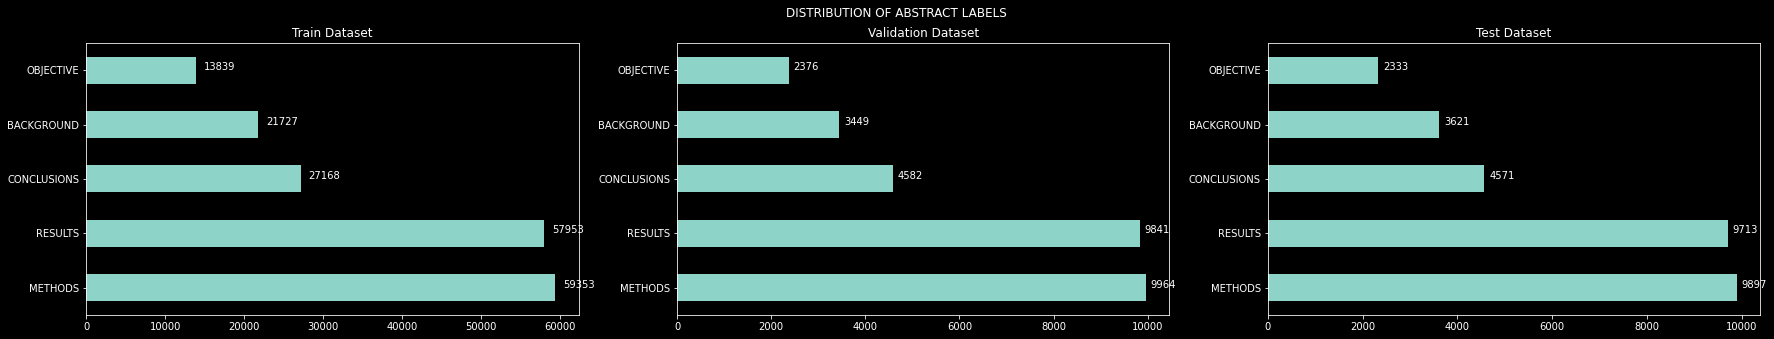

In [ ]:
# Check and compare the distribution of the abstract labels
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.figure(figsize=(30,5))
plt.suptitle('DISTRIBUTION OF ABSTRACT LABELS')

plt.subplot(131)
train_df['label'].value_counts().plot(kind='barh')
plt.title('Train Dataset')
for index, value in enumerate(train_df['label'].value_counts()):
    plt.text(x=value+1000, y=index, s=value, fontsize='medium', ma='center')

plt.subplot(132)
val_df['label'].value_counts().plot(kind='barh')
plt.title('Validation Dataset')
for index, value in enumerate(val_df['label'].value_counts()):
    plt.text(x=value+100, y=index, s=value, fontsize='medium', ma='center')

plt.subplot(133)
test_df['label'].value_counts().plot(kind='barh')
plt.title('Test Dataset')
for index, value in enumerate(test_df['label'].value_counts()):
    plt.text(x=value+100, y=index, s=value, fontsize='medium', ma='center')

plt.show()

Comments:

* In all Training, Validation, and Test sets, there is an imbalance between **RESULTS**, **METHODS** and **CONCLUSIONS**, **BACKGROUND**, **OBJECTIVES**. However, it is considered to be acceptable because depending on the purpose of each section in the research papers, the many or fewer times they occur in the abstract are flexible.

* For instance, the paper is motivative targeted to answer only one question or solve the only big problem but multiple diverse methods and techniques are required to handle.

-> Therefore, we have to pay more attention to deal with this kind of inequality dataset.

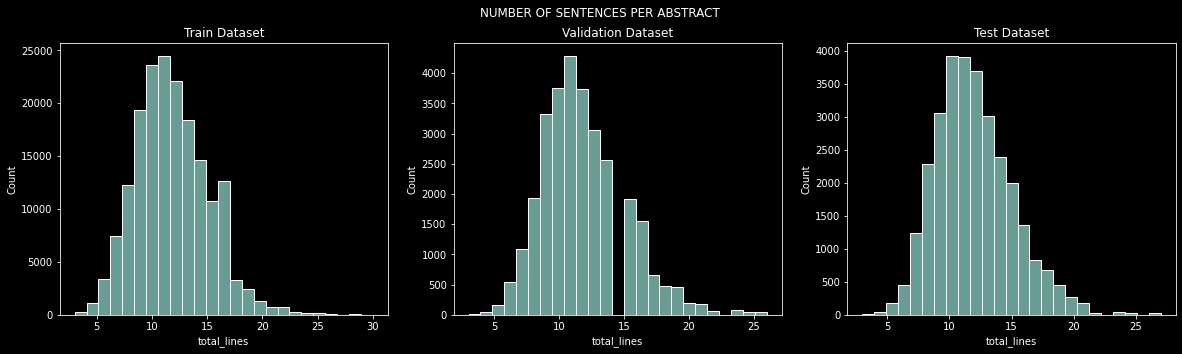

In [ ]:
# Check the distribution of the length of the abstracts
plt.figure(figsize=(20,5))
plt.suptitle('NUMBER OF SENTENCES PER ABSTRACT')

plt.subplot(131)
sns.histplot(train_df['total_lines'], bins=25)
plt.title('Train Dataset')

plt.subplot(132)
sns.histplot(val_df['total_lines'], bins=25)
plt.title('Validation Dataset')

plt.subplot(133)
sns.histplot(test_df['total_lines'], bins=25)
plt.title('Test Dataset')

plt.show()

Comments:
* Most of the abstracts have the length between 7 to 17 sentences.
* On the other hand, the minority is from 2 to 6 and from 16 to 35 sentences.
* Validation and Test Dataset have the most similar sentence length distribution

In [ ]:
# Get lists of sentences only for all train, val, and test datasets
train_text_list = list(train_df['text'])
val_text_list = list(val_df['text'])
test_text_list = list(test_df['text'])

len(train_text_list), len(val_text_list), len(test_text_list)

(180040, 30212, 30135)

In [ ]:
train_text_list[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
val_text_list[:5]

['ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
 'it is not clear whether these patients would benefit from antifungal treatment .',
 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
 'primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .']

In [ ]:
test_text_list[:5]

['this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
 "the percentage of patients with abnormal lfts decreased significantly from baseline to @-months ' follow-up ."]

In [ ]:
# # Get the class of labels from LabelEncoder
# number_of_classes = len(label_encoder.classes_)
# name_of_label_class = label_encoder.classes_
# print('Number of classes:', number_of_classes, '\n', name_of_label_class)

In [ ]:
# Create a list of sentence length
sentence_length = [len(sentence.split()) for sentence in train_text_list]

# Check the length of the longest sentence
print('The longest sentence has:', max(sentence_length), 'words.')

# Check the length of the shortest sentence
print('The shortest sentence has:', min(sentence_length), 'words.')

The longest sentence has: 296 words.
The shortest sentence has: 1 words.


In [ ]:
# Check the average spread of sentence length so as to find out the most general shape (length) for our data set
average_sentence_length = round(np.mean(sentence_length))
print('The average length of a sentence is:', average_sentence_length, 'words.')

The average length of a sentence is: 26 words.


In [ ]:
# Check for the majority with quantile range is 95%
major_sentence_length = int(np.percentile(sentence_length, 95))
print('95% of the total sentences has:', major_sentence_length, 'words.')

95% of the total sentences has: 55 words.


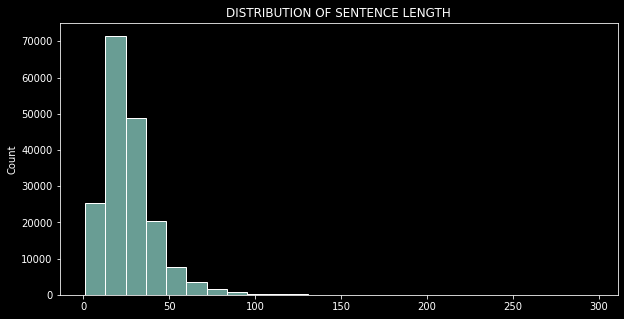

In [ ]:
# Visualize the distribution of sentence_length
import seaborn as sns
plt.figure(figsize=(10,5))
plt.title('DISTRIBUTION OF SENTENCE LENGTH')
sns.histplot(data=sentence_length, bins=25)

Comments:
* The vast majority of length per sentence is under 55 words (tokens).
* The average length of a sentence in an abstract is 26 words (tokens).
* The longest sentence has: 296 words.
* The shortest sentence has: 1 words ~ no empty sentences.

In [ ]:
print('Original training dataset:' , len(train_text_list), 'sentences')
print('95% of majority sentence length:', round(len(train_text_list)*0.95), 'sentences')
print('5% of minority sentence length:', round(len(train_text_list)*0.05), 'sentences')

Original training dataset: 180040 sentences
95% of majority sentence length: 171038 sentences
5% of minority sentence length: 9002 sentences


Comments:

In general, 95% of the sentence length is under 54 words (tokens).

-> Therefore, 55 is chosen to be the maximum length threshold for text data vectorization output.

~ It would be an acceptable amount of 5% missing of the minor length (~ 9002 words).

In [ ]:
# Create a character-level tokenizer
# Create a function to split sentences into characters
def split_characters(text):
    text_split_list = ' '.join(list(text))
    return text_split_list

In [ ]:
# Apply split_character function to train dataset
train_character_list = [split_characters(sentence) for sentence in train_text_list]
val_character_list = [split_characters(sentence) for sentence in val_text_list]
test_character_list = [split_characters(sentence) for sentence in test_text_list]

train_character_list[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# Check the character length of each sentence
character_length = [len(sentence) for sentence in train_text_list]
average_character_length = np.mean(character_length)
average_character_length

149.3662574983337

In [ ]:
# Check for the majority with quantile range is 95%
major_character_length = int(np.percentile(character_length, 95))
print('95% of the total sentences has:', major_character_length, 'characters')

95% of the total sentences has: 290 characters


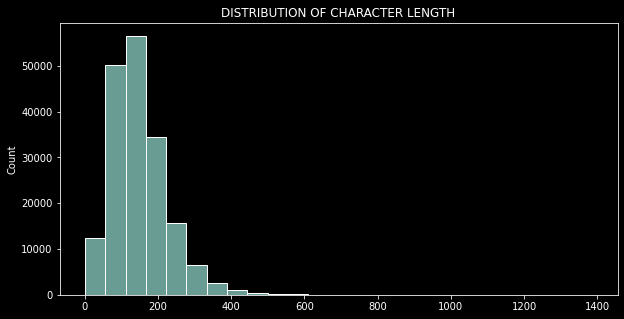

In [ ]:
# Visualize the distribution of character_length
import seaborn as sns
plt.figure(figsize=(10,5))
plt.title('DISTRIBUTION OF CHARACTER LENGTH')
sns.histplot(data=character_length, bins=25)

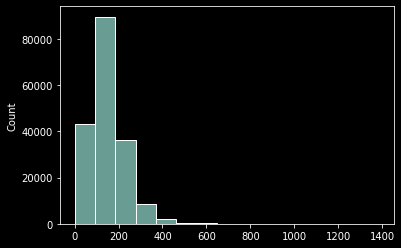

In [ ]:
# Check the distribution of sequences at a character-level
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(character_length, bins=15)

### Positional Embeddings
* Line numbers
* Total Lines

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


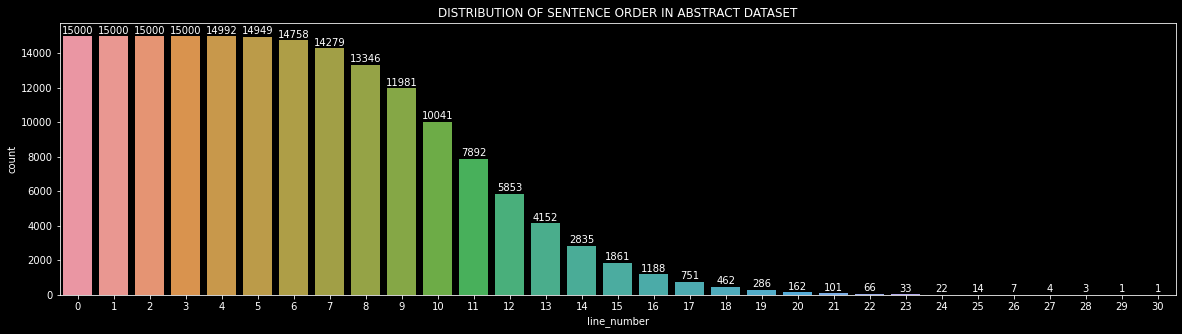

In [ ]:
# Check all available line numbers in the training dataset and their distribution
plt.figure(figsize=(20,5))
sns.countplot(train_df['line_number'])
plt.title(label='DISTRIBUTION OF SENTENCE ORDER IN ABSTRACT DATASET')
for index, value in enumerate(train_df['line_number'].value_counts()):
    plt.text(x=index, y=value+150, s=value, fontsize='medium', ha='center')

In [ ]:
total_line_number = train_df['line_number'].count()
minor_line_number = train_df['line_number'][train_df['line_number'] > 15].count()
minor_line_percentage = round(minor_line_number/total_line_number*100, 2)
print(f'The total number of lines for minor line number is {minor_line_number} occupying nearly {minor_line_percentage} percent.')

The total number of lines for minor line number is 3101 occupying nearly 1.72 percent.


Comments:

The lines number from 0 to 15 take the vast majority of the whole training dataset (~98%)

-> Dropping the minority lines number above 15 lines ~ 3101 lines (~1.72%) is acceptable.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'DISTRIBUTION OF TOTAL LINES IN ABSTRACT DATASET')

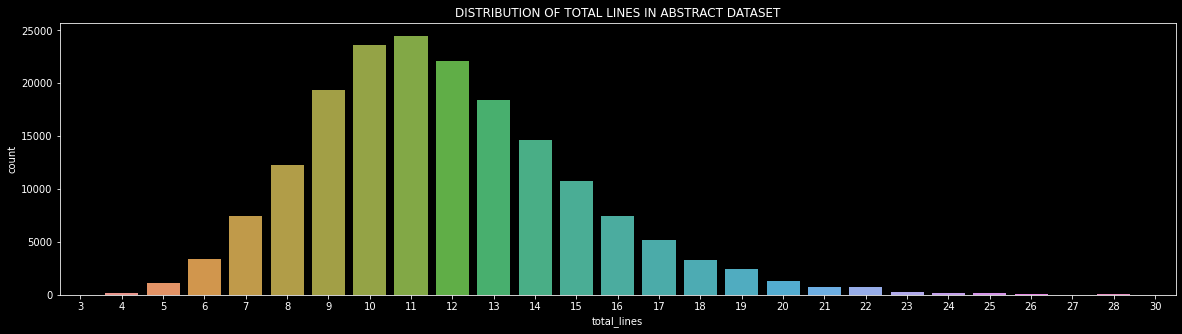

In [ ]:
# Check all available total line numbers in the training dataset and their distribution
plt.figure(figsize=(20,5))
sns.countplot(train_df['total_lines'])
plt.title(label='DISTRIBUTION OF TOTAL LINES IN ABSTRACT DATASET')

In [ ]:
train_df['total_lines'].describe()

count    180040.000000
mean         11.789136
std           3.236095
min           3.000000
25%          10.000000
50%          11.000000
75%          14.000000
max          30.000000
Name: total_lines, dtype: float64

In [ ]:
number_of_total_lines = train_df['total_lines'].count()
minor_number_of_total_lines = train_df['total_lines'][train_df['total_lines'] > 20].count()
minor_number_of_total_lines_percentage = round(minor_number_of_total_lines/number_of_total_lines*100, 2)
print(f'The total number for total minor line number is {minor_number_of_total_lines} occupying nearly {minor_number_of_total_lines_percentage} percent.')

The total number for total minor line number is 2373 occupying nearly 1.32 percent.


Comments:

The lines number from 0 to 20 take the vast majority of the whole training dataset (~98%)

-> Dropping the minority lines number above 20 total lines ~ 2373 lines (~1.32%) is acceptable.

#### SAVE DATASET FOR MODEL TRAINING

In [ ]:
# Save the dataframe as pickle file
train_df.to_pickle('/content/gdrive/MyDrive/abstract_section_classification/data/train_dataset.pkl')
val_df.to_pickle('/content/gdrive/MyDrive/abstract_section_classification/data/val_dataset.pkl')
test_df.to_pickle('/content/gdrive/MyDrive/abstract_section_classification/data/test_dataset.pkl')

### DISCOVER MORE:

1. Training, Validation, and Testing data preparation: https://colab.research.google.com/drive/1rN-BfkA5Vc5nMToka_Pyr1q1DtxlXxki#scrollTo=FhIyNphGtFAY

2. Model creation and training: https://colab.research.google.com/drive/1ZrEdJBmeU0FDtNN5F_s0eU6yqvAEIPMt#scrollTo=d0etEZ_Mpqw1&uniqifier=1

3. Demo data preprocessing and model prediction
https://colab.research.google.com/drive/1l3fQn91sOx7KbsLBiIPls_Aaw9CvAkFY#scrollTo=vS0raMb7tNqR